In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, r2_score
from sklearn.model_selection import KFold
import xgboost as xgb

In [2]:
df = pd.read_csv("C:/work/Kaggle/traffic/train_dataset_train.csv")
dft = pd.read_csv("C:/work/Kaggle/traffic/test_dataset_test.csv")

df.shape, dft.shape

((1091021, 12), (561890, 10))

In [3]:
df.columns

Index(['id', 'ticket_id', 'ticket_type_nm', 'entrance_id', 'entrance_nm',
       'station_id', 'station_nm', 'line_id', 'line_nm', 'pass_dttm',
       'time_to_under', 'label'],
      dtype='object')

In [8]:
def add_feas(df):
    df['cnt'] = df.groupby('ticket_id')['id'].transform('count')
    D = pd.to_datetime(df['pass_dttm'])
    df['day'] = D.dt.day_of_week
    df['time'] = D.dt.hour*60 + D.dt.minute + D.dt.second/60
    df['mean_time'] = df.groupby('ticket_id')['time'].transform('mean')

add_feas(df)
add_feas(dft)

In [44]:
def calc_weihgts(L,k=100):
    n = L.nunique()
    F = (L.shape[0] + k*n) / (L.value_counts() + k) / n
    return L.map(F)

df['weight'] = calc_weihgts(df['label'])

## Прогнозирование label

In [61]:
def find_label_(v):
    return v.groupby('label')['weight'].sum().idxmax()

def calc_label_model(df,feas):
    g = df.groupby(feas).apply(find_label_)
    g.index = g.index.to_flat_index()
    g.name = tuple(feas)
    return g

def predict_label(df,g):
    n = list(g.name)
    return df[n].apply(tuple,axis=1).map(g) if len(n)>1 else df[n[0]].map(g)

def predict_label_base(df,df1):
    g0 = calc_label_model(df,['station_id'])
    p0 = predict_label(df1,g0)

    g1 = calc_label_model(df,['station_id','ticket_type_nm'])
    p1 = predict_label(df1,g1)

    p = p0
    p[p1.notna()] = p1
    return p

dft['label'] = predict_label_base(df,dft)

recall_score(df['label'],predict_label_base(df,df), average='macro')

0.12492230566942372

## Прогнозирование time_to_under

In [9]:
def form_table(df):
    dcols = ['ticket_type_nm', 'station_id', 'line_id']
    cols = ['cnt', 'day', 'time', 'mean_time'] + dcols
    return pd.get_dummies(df[cols], columns=dcols)

X = form_table(df)
X

,cnt,day,time,mean_time,ticket_type_nm_1 сутки ЕДИНЫЙ ТК,ticket_type_nm_1 сутки Пригород ТК,ticket_type_nm_3 суток Единый ТК,ticket_type_nm_30 дней,ticket_type_nm_30 дней Пригород,ticket_type_nm_30 дней ЕДИНЫЙ ТК,...,line_id_7,line_id_8,line_id_9,line_id_10,line_id_11,line_id_12,line_id_13,line_id_14,line_id_15,line_id_81
0,1,0,300.216667,300.216667,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,5,0,300.900000,611.376667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,300.916667,603.313333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,301.216667,644.688889,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,302.916667,605.666667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091016,1,0,174.833333,174.833333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1091017,2,0,186.033333,652.591667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1091018,1,0,197.000000,197.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1091019,1,0,203.500000,203.500000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
Xt = form_table(dft)
Xt

,cnt,day,time,mean_time,ticket_type_nm_1 сутки ЕДИНЫЙ ТК,ticket_type_nm_1 сутки Пригород ТК,ticket_type_nm_3 суток Единый ТК,ticket_type_nm_30 дней,ticket_type_nm_30 дней Пригород,ticket_type_nm_30 дней ЕДИНЫЙ ТК,...,line_id_7,line_id_8,line_id_9,line_id_10,line_id_11,line_id_12,line_id_13,line_id_14,line_id_15,line_id_81
0,4,0,300.050000,486.729167,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,300.750000,566.116667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,300.866667,655.336111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,300.966667,603.072222,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,301.650000,487.883333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561885,1,0,93.183333,93.183333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
561886,2,0,123.983333,302.675000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
561887,1,0,171.566667,171.566667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
561888,3,0,178.166667,559.783333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
set(X.columns) - set(Xt.columns), set(Xt.columns) - set(X.columns)

({'station_id_13006',
  'ticket_type_nm_Билет 1 сутки ЕДИНЫЙ',
  'ticket_type_nm_ВЕСБ МО (тип 6)',
  'ticket_type_nm_ВЕСБ МО с сопровождающим'},
 {'ticket_type_nm_СК студента на 3 месяца'})

In [20]:
for c in set(X.columns) - set(Xt.columns):
    Xt[c] = 0

In [10]:
Y = df['time_to_under']

In [ ]:
%%time
bst = xgb.XGBRegressor(**{'objective':'reg:squarederror',
                           'reg_lambda':0.5, 'n_estimators':300, 'max_depth':4, 'learning_rate':0.3, 'random_state':0}
                       ).fit(X,Y)

dft['time_to_under'] = bst.predict(Xt[X.columns])
dft[['id','time_to_under','label']].to_csv('C:/work/Kaggle/traffic/sln/sln_b3.csv',index=False)

## Дальнейший код можно не запускать. Решение получено

In [29]:
Y1 = df['time'] + df['time_to_under']

0
1
2
3
0.5620136500416321


<AxesSubplot:>

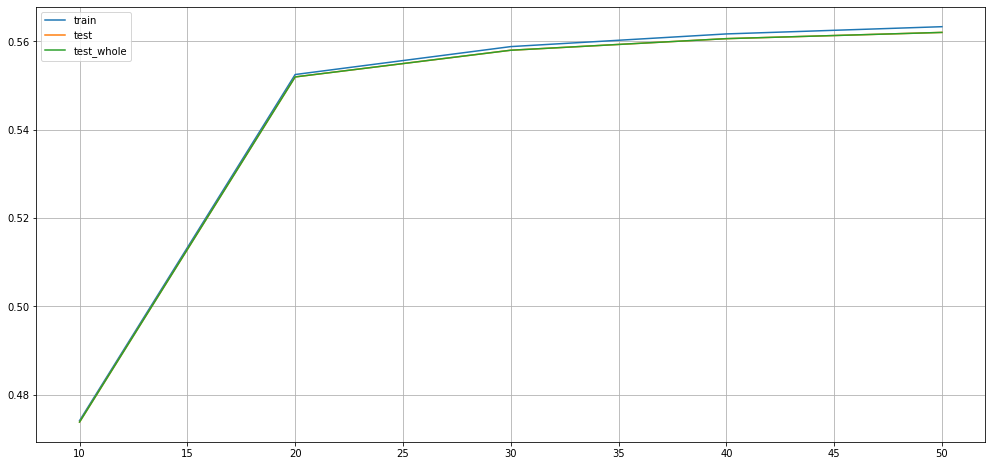

In [11]:
def calc_crossval_pred(X,Y,params):
    bst = xgb.XGBRegressor(**params)
    nt = list(range(10,params['n_estimators']+1,10))
    n_splits=4
    scores = np.zeros((2,n_splits,len(nt)))#nt.shape[0]))
    preds = np.zeros((len(nt),X.shape[0]))

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    for i_fold, (train, test) in enumerate(kf.split(X)):
        print(i_fold)
        X_train = X.iloc[train]
        y_train = Y.iloc[train]
        X_test = X.iloc[test]
        y_test = Y.iloc[test]

        bst.fit(X_train, y_train)
        
        for i_sample, (x, y) in enumerate([(X_train,y_train), (X_test,y_test)]):
            for i,n_trees in enumerate(nt):
                #print(n_trees)
                p = bst.predict(x,iteration_range=(0,n_trees))
                scores[i_sample,i_fold,i] = r2_score(y, p)
                
                if i_sample==1:
                    preds[i,test] = p


    curve = pd.DataFrame(scores.mean(axis=1)).T
    curve.columns = ['train', 'test']
    curve['test_whole'] = [r2_score(Y, p) for p in preds]
    curve.index = nt
    return {'params':params, 'curve':curve, 'scores':scores, 'preds':preds, 'max_score':curve['test'].max(), 'feas':X.columns}

res = []
res.append(calc_crossval_pred(X,Y,{'objective':'reg:squarederror',# 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                  'reg_lambda':0.5, 'n_estimators':50, 'max_depth':4, 'learning_rate':0.2, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),grid='on')#,ylim=(0.94,1.01)

0
1
2
3
0.5672203422157683
Wall time: 4h 32min 58s


<AxesSubplot:>

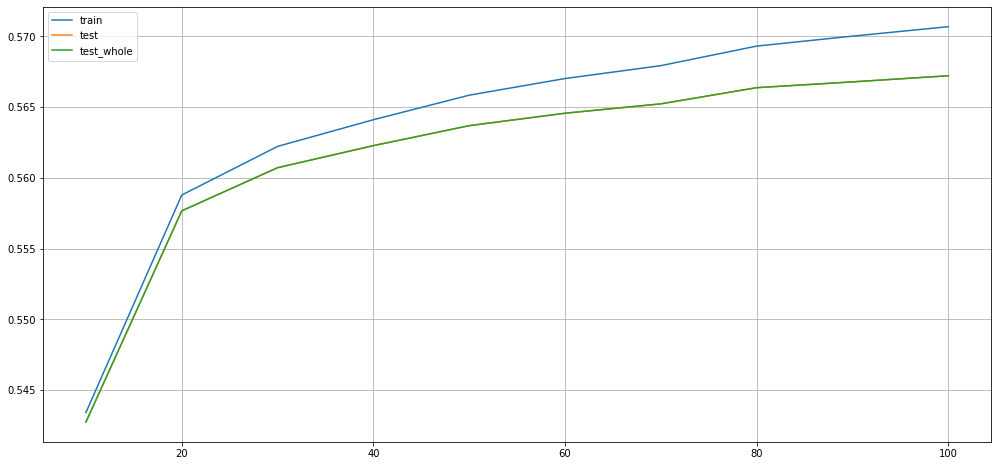

In [24]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'reg:squarederror',# 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                  'reg_lambda':0.5, 'n_estimators':100, 'max_depth':4, 'learning_rate':0.3, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),grid='on')#,ylim=(0.94,1.01)

0
1
2
3
0.5705139219735679
Wall time: 3h 11min 25s


<AxesSubplot:>

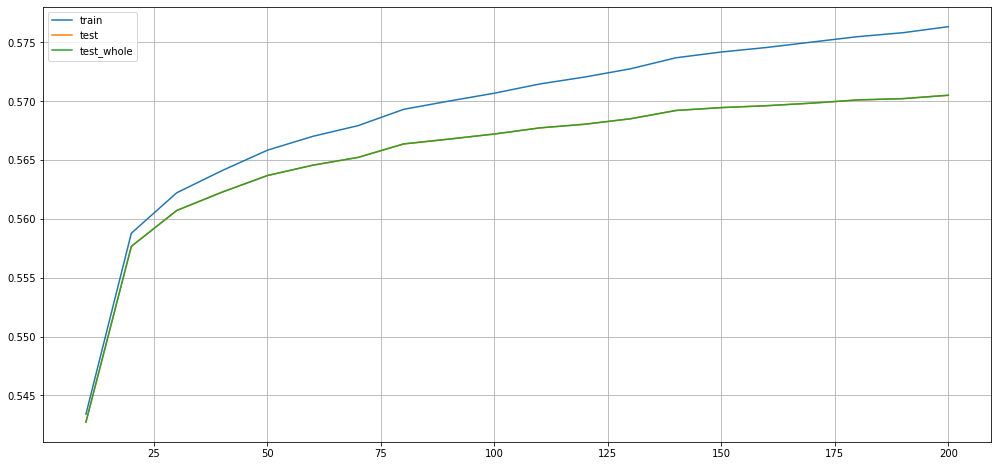

In [34]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'reg:squarederror',# 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                  'reg_lambda':0.5, 'n_estimators':200, 'max_depth':4, 'learning_rate':0.3, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),grid='on')#,ylim=(0.94,1.01)

0
1
2
3
0.24479058838859685
Wall time: 1h 16min 51s


<AxesSubplot:>

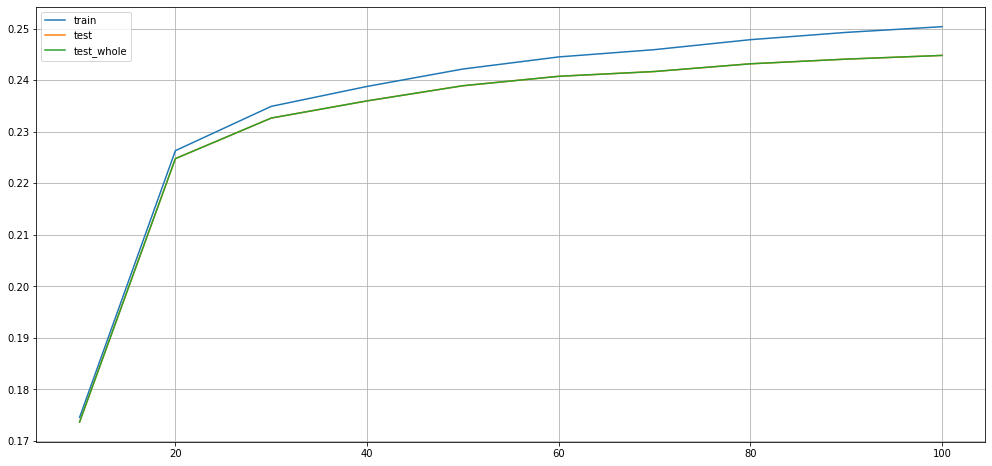

In [30]:
%%time
res.append(calc_crossval_pred(X,Y1,{'objective':'reg:squarederror',# 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                  'reg_lambda':0.5, 'n_estimators':100, 'max_depth':4, 'learning_rate':0.3, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),grid='on')#,ylim=(0.94,1.01)

0.5674570399577261


<AxesSubplot:>

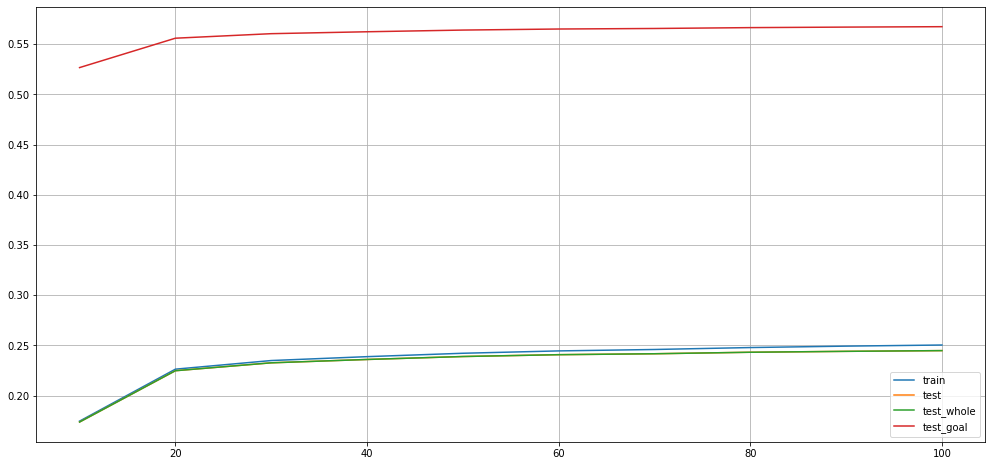

In [33]:
res[-1]['curve']['test_goal'] = [r2_score(Y, p-df['time']) for p in res[-1]['preds']]

print(res[-1]['curve']['test_goal'].max())
res[-1]['curve'].plot(figsize=(17,8),grid='on')#,ylim=(0.94,1.01)

In [14]:
%%time
bst = xgb.XGBRegressor(**{'objective':'reg:squarederror',
                           'reg_lambda':0.5, 'n_estimators':50, 'max_depth':4, 'learning_rate':0.2, 'random_state':0}
                       ).fit(X,Y)

Wall time: 10min 49s


In [25]:
%%time
bst = xgb.XGBRegressor(**{'objective':'reg:squarederror',
                           'reg_lambda':0.5, 'n_estimators':100, 'max_depth':4, 'learning_rate':0.3, 'random_state':0}
                       ).fit(X,Y)

Wall time: 18min 43s


In [35]:
%%time
bst = xgb.XGBRegressor(**{'objective':'reg:squarederror',
                           'reg_lambda':0.5, 'n_estimators':200, 'max_depth':4, 'learning_rate':0.3, 'random_state':0}
                       ).fit(X,Y)

Wall time: 48min 32s


In [41]:
%%time
bst = xgb.XGBRegressor(**{'objective':'reg:squarederror',
                           'reg_lambda':0.5, 'n_estimators':300, 'max_depth':4, 'learning_rate':0.3, 'random_state':0}
                       ).fit(X,Y)

Wall time: 1h 5min 48s


In [15]:
imp = pd.DataFrame({t:bst.get_booster().get_score(importance_type=t) for t in['gain','weight','total_gain']}
            ).sort_values('total_gain')
imp

,gain,weight,total_gain
station_id_7005,4.120442e+04,1.0,4.120442e+04
line_id_11,9.687175e+04,1.0,9.687175e+04
station_id_14030,1.349646e+05,1.0,1.349646e+05
station_id_9001,1.380883e+05,1.0,1.380883e+05
station_id_9023,1.417553e+05,1.0,1.417553e+05
...,...,...,...
day,1.442371e+07,67.0,9.663885e+08
ticket_type_nm_Социальная карта москвича,4.333053e+07,23.0,9.966022e+08
mean_time,1.670851e+07,101.0,1.687560e+09
cnt,5.948828e+07,92.0,5.472922e+09


In [40]:
imp.iloc[-60:]

,gain,weight,total_gain
station_id_1022,2.666806e+05,1.0,2.666806e+05
station_id_8008,2.682865e+05,1.0,2.682865e+05
station_id_11006,2.814990e+05,1.0,2.814990e+05
station_id_2011,3.103835e+05,1.0,3.103835e+05
station_id_6007,3.228255e+05,1.0,3.228255e+05
station_id_5004,3.881132e+05,1.0,3.881132e+05
station_id_1006,4.533315e+05,1.0,4.533315e+05
station_id_6002,4.775515e+05,1.0,4.775515e+05
station_id_9022,4.900327e+05,1.0,4.900327e+05
station_id_3009,2.459296e+05,2.0,4.918591e+05


In [42]:
dft['time_to_under'] = bst.predict(Xt[X.columns])
dft[['id','time_to_under','label']].to_csv('C:/work/Kaggle/traffic/sln/sln_b3.csv',index=False)

In [38]:
((dft['time'] + dft['time_to_under'])/60).max()

25.032233818901908

In [39]:
(((dft['time'] + dft['time_to_under'])/60)>24).sum()

49

In [70]:
(pd.read_csv("C:/work/Kaggle/traffic/sln/sln_b3.csv") != 
 pd.read_csv("C:/work/Kaggle/traffic/sln/sln_b3_.csv")).sum()

id               0
time_to_under    0
label            0
dtype: int64